# # Anadolu Sigorta Datathon Challenge

## References
* https://keras.io/examples/vision/oxford_pets_image_segmentation/
* https://www.kaggle.com/paulorzp/run-length-encode-and-decode

## Libraries

In [1]:
import os

from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow.keras.layers.experimental.preprocessing as preprocessing
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import layers
from tensorflow.keras.metrics import MeanIoU
from keras import backend as K

import random

## Helpers

In [2]:
class AnadoluSigorta(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = img_to_array(load_img(path, target_size=img_size))
            img /= 255.0
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 255 and 0. Make them 1, 0 for prediction:
            y[j] = np.where(y[j] == 255, 1, 0)
        return x, y

In [3]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    #x = layers.Dropout(0.50)(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        #x = layers.Dropout(0.50)(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)
        #x = layers.Dropout(0.50)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes - 1, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [4]:
def unet(input_size = (256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    #drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    #drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    return model

In [5]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

## Settings & Parameters

In [6]:
type_names = ['id1'] 

input_dir = "/kaggle/input/datathon-challenge/Training_Imgs/Training_Imgs/"
target_dir = "/kaggle/input/datathon-challenge/Training_Masks/Training_Masks/"

img_size = (256, 256)
num_classes = 2
batch_size = 16
epochs = 100
val_samples = 500

optimizer = "adam"

## Input data

In [7]:
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpeg")
    ]
)

## Loop over for 4 type of classes and get 4 models

Number of samples: 1401
Number of masks: 1401
Epoch 1/100
56/56 [==============================] - 55s 990ms/step - loss: 1.1986 - dice_coef: 0.1293 - val_loss: 0.4862 - val_dice_coef: 0.0224
Epoch 2/100
56/56 [==============================] - 41s 725ms/step - loss: 0.3114 - dice_coef: 0.0862 - val_loss: 0.3065 - val_dice_coef: 0.0990
Epoch 3/100
56/56 [==============================] - 40s 707ms/step - loss: 0.3091 - dice_coef: 0.0889 - val_loss: 0.3076 - val_dice_coef: 0.0850
Epoch 4/100
56/56 [==============================] - 40s 723ms/step - loss: 0.2941 - dice_coef: 0.0918 - val_loss: 0.3158 - val_dice_coef: 0.1155
Epoch 5/100
56/56 [==============================] - 40s 717ms/step - loss: 0.2967 - dice_coef: 0.0927 - val_loss: 0.3199 - val_dice_coef: 0.0675
Epoch 6/100
56/56 [==============================] - 40s 713ms/step - loss: 0.2919 - dice_coef: 0.0913 - val_loss: 0.2958 - val_dice_coef: 0.0990
Epoch 7/100
56/56 [==============================] - 40s 710ms/step - loss: 0.

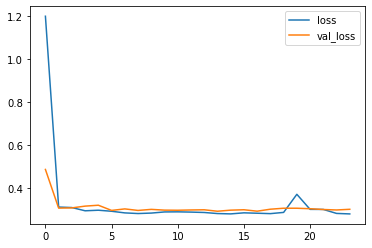

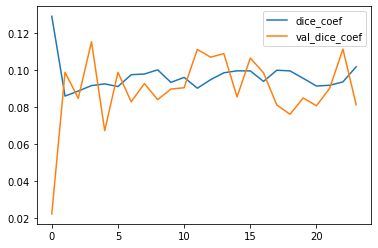

In [8]:
for type_name in type_names:
    
    
    target_img_paths = sorted(
        [
            os.path.join(target_dir, fname)
            for fname in os.listdir(target_dir)
            if fname.endswith(".png") and f'{type_name}' in fname
        ]
    )

    print("Number of samples:", len(input_img_paths))
    print("Number of masks:", len(target_img_paths))

    #for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    #    print(input_path, "|", target_path)
        
    # Free up RAM in case the model definition cells were run multiple times
    keras.backend.clear_session()
    
    # Build model
    model = unet()
    #model.summary()
    
    # Split our img paths into a training and a validation set
    random.Random(1337).shuffle(input_img_paths)
    random.Random(1337).shuffle(target_img_paths)
    train_input_img_paths = input_img_paths[:-val_samples]
    train_target_img_paths = target_img_paths[:-val_samples]
    val_input_img_paths = input_img_paths[-val_samples:]
    val_target_img_paths = target_img_paths[-val_samples:]

    # Instantiate data Sequences for each split
    train_gen = AnadoluSigorta(
        batch_size, img_size, train_input_img_paths, train_target_img_paths
    )
    val_gen = AnadoluSigorta(batch_size, img_size, val_input_img_paths, val_target_img_paths)
    
    # Configure the model for training.
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[dice_coef])

    filepath = f"anadolu_segmentation_{type_name}.h5"

    callbacks = [
        #keras.callbacks.ModelCheckpoint(filepath,
        #                                save_best_only=True,
        #                                verbose=1,
        #                                monitor='val_dice_coef',
        #                                mode='max'),
        keras.callbacks.EarlyStopping(monitor="val_loss",
                                      min_delta=0,
                                      patience=10,
                                      mode="min",
                                      restore_best_weights=True)
                                      
    ]

    # Train the model, doing validation at the end of each epoch.
    history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)
        
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot() 
    history_df.loc[:, ['dice_coef', 'val_dice_coef']].plot()
                                      
    print("Max val dice coef: {}".format(history_df['val_dice_coef'].max()))
    print("Max dice coef: {}".format(history_df['dice_coef'].max()))
    
    model.save(filepath)